# CNN for Bottle Label Defects Classification

This model is to build a CNN model that can classify bottle label based on their differences: without wrinkle or with wrinkle. 

The model used the following layers for all the steps:
 - Conv2D: stride 2, padding is "SAME"
 - BatchNormalization
 - ReLU
 - Flatten the previous output.
 - SeparableConv2D
 - Do not softmax. This will result in 6 neurons in the output layer, which then get passed later to a softmax.

The model training includes the following items: 
    1. Hyper parameter optimization; 
    2. Number of layers test; 
    3. Training time and Run time test; 
    4. Test the minimum amount of images needed for a good model; 
    5. Test the minimum amount of sample bottles needed for a good model; 
    6. Test the minimum resolution of image needed for a good training. 
    

This structure is based on keras computer vision example.

In [1]:

# This will prompt for authorization.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'CS231N_Final_Project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/My Drive/CS231N_Final_Project/cs231n/datasets/'
/content
bash: get_datasets.sh: No such file or directory
/content/drive/My Drive/CS231N_Final_Project


In [2]:
# TensorFlow 2.0 and keras environment

import numpy as np
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

In [3]:
# Hyper parameters and settings

# image size is related to the convnet size 180
image_size = (180, 180) 
# default batch norm size is 32, which is the best
batch_size = 32         # 16
# When the good bottle label background is consistent with some 
#   orientation variation, the epoch number can be 60.
# But when the good bottle label keep changing, then need epoch number to be 100.
# epochs: 40, 60, 80, 100
epochs     = 100

In [4]:
# Generate a dataset

# Automatically randomly shuffle the images to train dataset and evaluation dataset.
# When there are some wrong images, the result can be very different due to this randomness.

train_dataset = K.preprocessing.image_dataset_from_directory(
    "WrinkleImages1",
    validation_split=0.2, # Randomly shuffle the dataset. 
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_dataset = K.preprocessing.image_dataset_from_directory(
    "WrinkleImages1",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


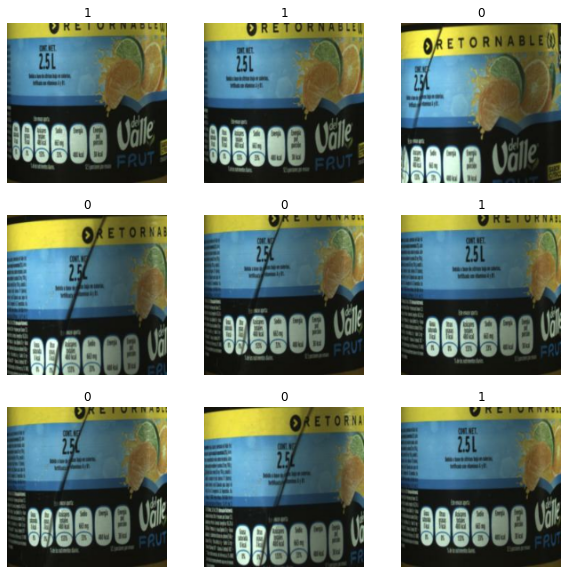

In [5]:
# Visualize the dataset

# class 0 - bad bottle label with wrinkle defects
# class 1 - good bottle label without wrinkle defects

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.imshow(images[1][1])
        plt.title(int(labels[i]))
        #plt.title(labels[train[0][1]])
        plt.axis("off")



In [6]:
# AUGMENTATION:
# - No need to rotate the image
# - Horizontal flip is helpful
# - rescaling
# - Randomzoom
# - resizing
data_augmentation = K.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0),
    ]
)

        #layers.experimental.preprocessing.randomzoom(),
        #layers.experimental.preprocessing.RandomRotation(0),
        #layers.experimental.preprocessing.RandomRotation(0),

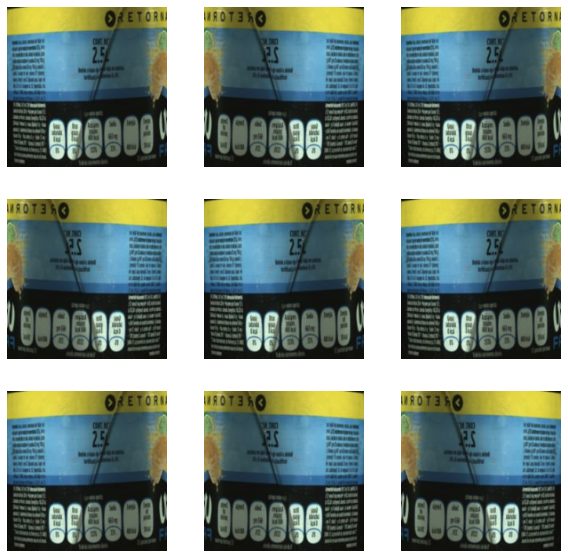

In [7]:
# visualize the augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [8]:
# Preprocessing 
augmented_train_dataset = train_dataset.map(
  lambda x, y: (data_augmentation(x, training=True), y)
  )


In [9]:
# Configure the dataset for performance
train_dataset = train_dataset.prefetch(buffer_size=32)
val_dataset   = val_dataset.prefetch(buffer_size=32)


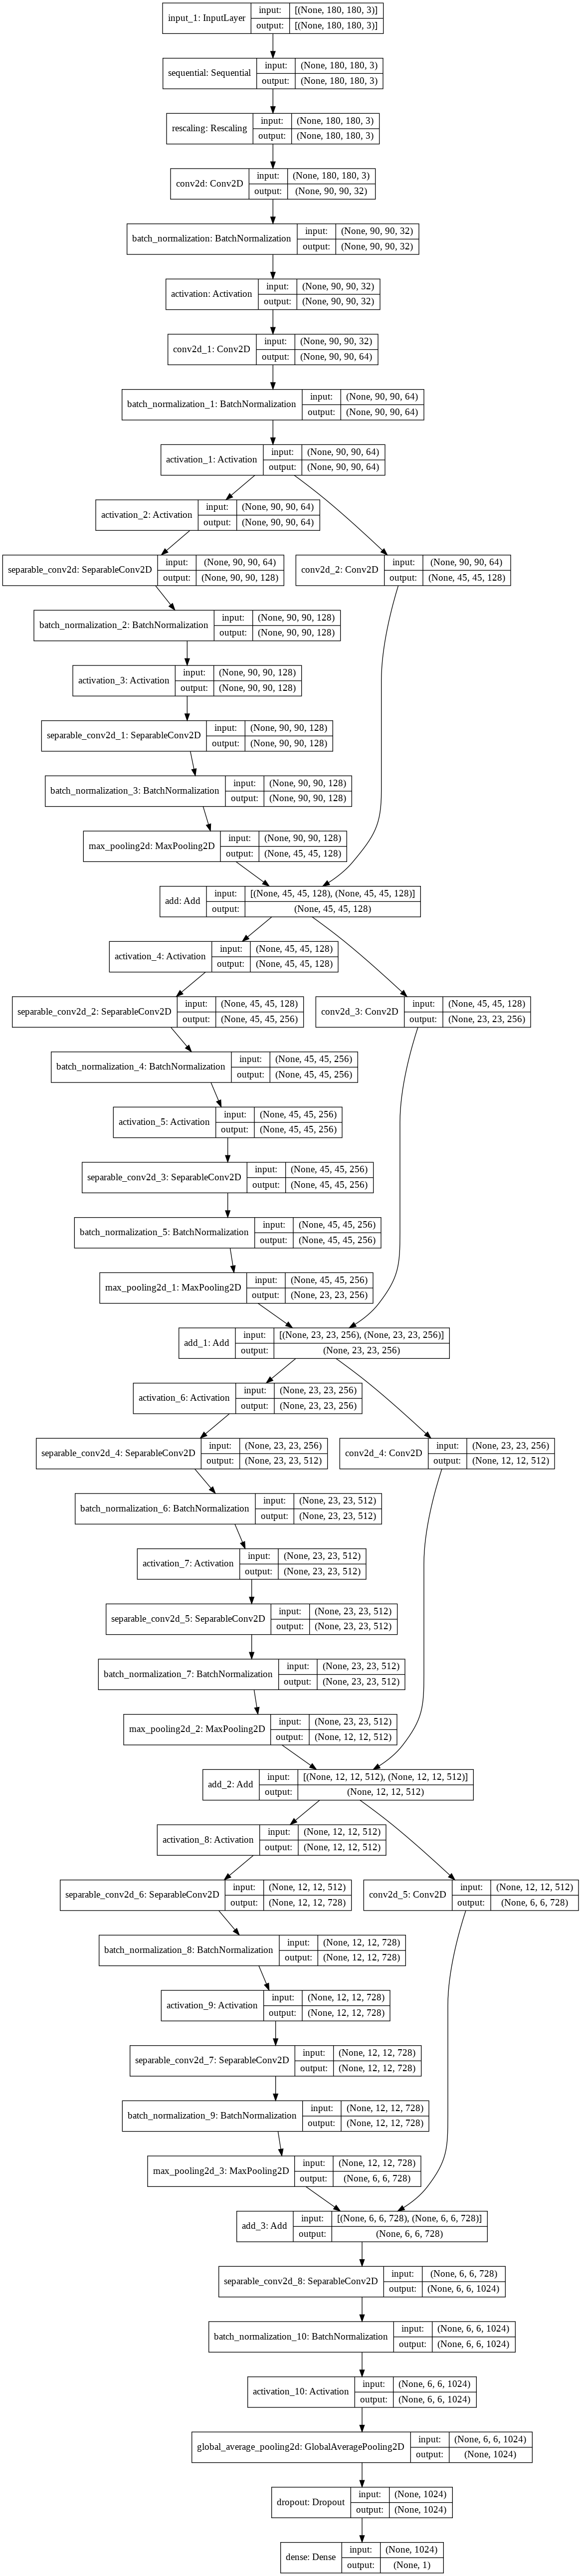

In [10]:
# CNN model
def make_model(input_shape, num_classes):
    inputs = K.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    # data preprocessing - rescale
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    # padding
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    # batch norm
    x = layers.BatchNormalization()(x)
    # activate for the first layer
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual


    #### First unit
    # relu activation from previous
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    # relu activation
    x = layers.Activation("relu")(x)
    # seperable conv
    x = layers.SeparableConv2D(128, 3, padding="same")(x)
    # batch norm
    x = layers.BatchNormalization()(x)
    # max pooling
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    # Project residual
    residual=layers.Conv2D(128,1,strides=2,padding="same")(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual
    
    #### second unit
    # relu activation from previous
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    # relu activation
    x = layers.Activation("relu")(x)
    # seperable conv
    x = layers.SeparableConv2D(256, 3, padding="same")(x)
    # batch norm
    x = layers.BatchNormalization()(x)
    # max pooling
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    # Project residual
    residual=layers.Conv2D(256,1,strides=2,padding="same")(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    #### thirs unit
    # relu activation from previous
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    # relu activation
    x = layers.Activation("relu")(x)
    # seperable conv
    x = layers.SeparableConv2D(512, 3, padding="same")(x)
    # batch norm
    x = layers.BatchNormalization()(x)
    # max pooling
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    # Project residual
    residual=layers.Conv2D(512,1,strides=2,padding="same")(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    #### forth unit
    # relu activation from previous
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(728, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    # relu activation
    x = layers.Activation("relu")(x)
    # seperable conv
    x = layers.SeparableConv2D(728, 3, padding="same")(x)
    # batch norm
    x = layers.BatchNormalization()(x)
    # max pooling
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    # Project residual
    residual=layers.Conv2D(728,1,strides=2,padding="same")(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    ### end unit
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    #x = layers.SeparableConv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    # activation function
    activation = "sigmoid"
    units = 1
    # dropout: 0.2, 0.4, 0.5, 0.6, 0.65
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return K.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
K.utils.plot_model(model, show_shapes=True)



In [11]:
# train the model

callbacks = [
    K.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=K.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
tic = time.perf_counter()

# train model
history = model.fit(
    train_dataset, epochs=epochs, callbacks=callbacks, validation_data=val_dataset,
)

toc = time.perf_counter()

# Time needed to train the model
trainTime = (toc-tic)*1000
trainTimeShort = np.trunc(trainTime)
print("Training time = " + str(trainTimeShort) +"ms")


Epoch 1/100
13/13 [==============================] - 10s 274ms/step - loss: 0.3949 - accuracy: 0.8125 - val_loss: 0.6924 - val_accuracy: 0.4900


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
13/13 [==============================] - 3s 199ms/step - loss: 0.0778 - accuracy: 0.9675 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 3/100
13/13 [==============================] - 3s 197ms/step - loss: 0.0998 - accuracy: 0.9600 - val_loss: 0.7111 - val_accuracy: 0.5100
Epoch 4/100
13/13 [==============================] - 3s 202ms/step - loss: 0.0317 - accuracy: 0.9875 - val_loss: 0.7256 - val_accuracy: 0.5100
Epoch 5/100
13/13 [==============================] - 3s 198ms/step - loss: 0.0095 - accuracy: 0.9975 - val_loss: 0.7396 - val_accuracy: 0.5100
Epoch 6/100
13/13 [==============================] - 3s 204ms/step - loss: 0.0061 - accuracy: 0.9975 - val_loss: 0.7542 - val_accuracy: 0.5100
Epoch 7/100
13/13 [==============================] - 3s 199ms/step - loss: 0.0081 - accuracy: 0.9975 - val_loss: 0.7515 - val_accuracy: 0.5100
Epoch 8/100
13/13 [==============================] - 3s 198ms/step - loss: 0.0651 - accuracy: 0.9750 - val_loss: 0.8105 - val_accuracy: 0.5100

1/1 - 0s - loss: 7.7304 - accuracy: 0.5312


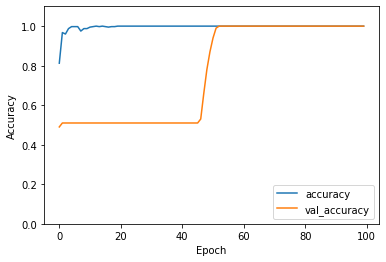

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(images,  labels, verbose=2)

1/1 - 0s - loss: 7.7304 - accuracy: 0.5312


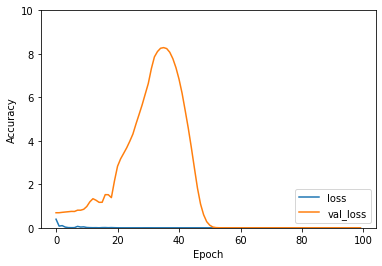

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 10])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(images,  labels, verbose=2)

Predict time = 44.0ms
This image is 100.00 percent bad and 0.00 percent good.


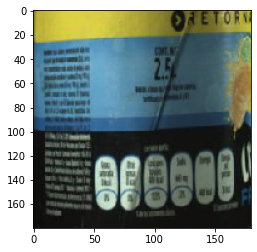

In [20]:

# 1. Predict new images
img = K.preprocessing.image.load_img(
    "WrinkleImages1/bad/83.jpg",  #65, 6,16,21,30,41, 71, 83
    #"WrinkleImages2/good/100.jpg",  # 9,27,67,114
    #"WrinkleImagesTest/aug4.jpg",
    target_size=image_size
)
tic = time.perf_counter()
img_array = K.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
toc = time.perf_counter()

# 2. Evaluate the prediction run time
predictTime = (toc-tic)*1000
predictTimeShort = np.trunc(predictTime)
print("Predict time = " + str(predictTimeShort) +"ms")

# 3. Prediction result
score = predictions[0]
print(
    "This image is %.2f percent bad and %.2f percent good."
    % (100 * (1 - score), 100 * score)
)

# 4. Display prediction image
plt.imshow(img)